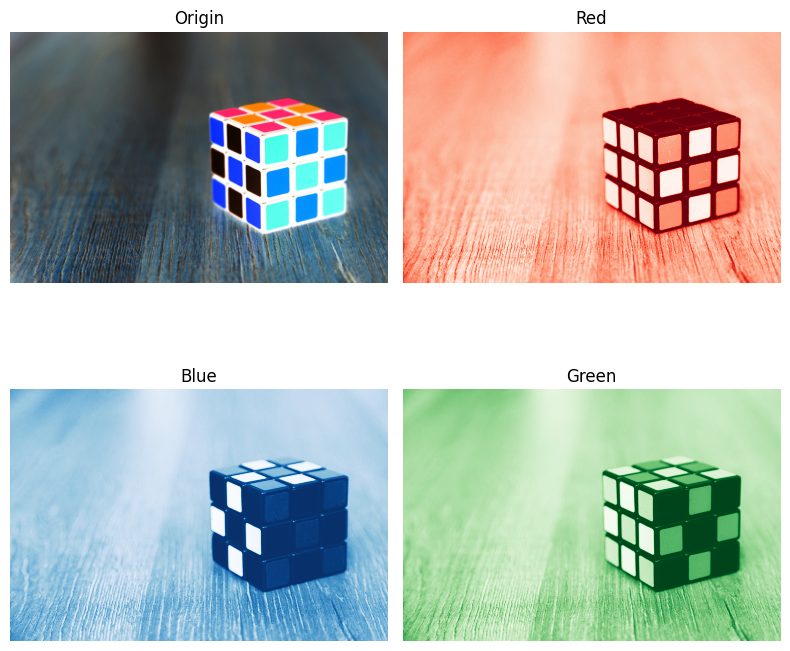

In [300]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rng

image = cv2.imread('images/square3.jpg')
image = 255 - image

blue, green, red = cv2.split(image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)


plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Origin')
plt.axis('off')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

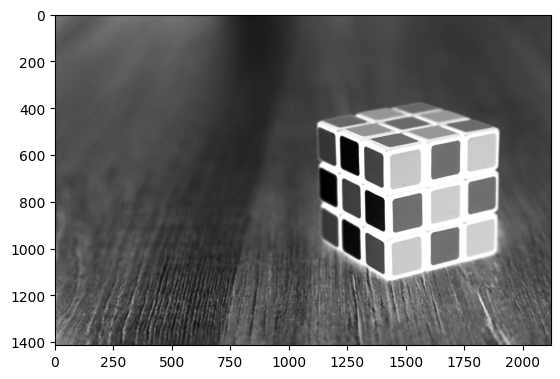

In [301]:
HP_gray_image = cv2.cvtColor(cv2.merge([blue, green, red],), cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
HP_gray_image = cv2.medianBlur(HP_gray_image,7)
plt.imshow(HP_gray_image,cmap="gray")

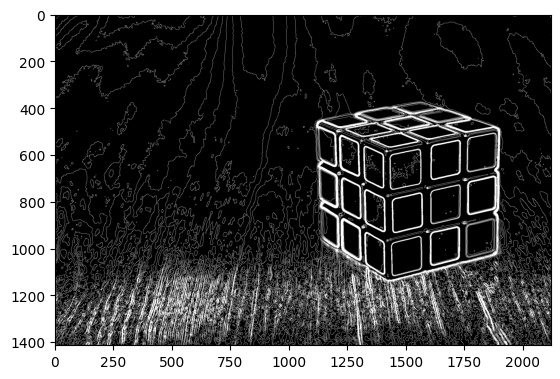

In [302]:
# threshold binario per identificare i bordi delle caselle nel cubo
blur = cv2.GaussianBlur(HP_gray_image, (7, 7), 0)
ret,threshold_image = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)
edged = cv2.Canny(threshold_image, 30, 200)

plt.imshow(edged)
for i in range(24):
    ret,threshold_image = cv2.threshold(blur,10*(i+2),255,cv2.THRESH_BINARY)
    edge = cv2.Canny(threshold_image, 30, 200)
    edged = cv2.add(edged,edge)

plt.imshow(edged, cmap="gray")

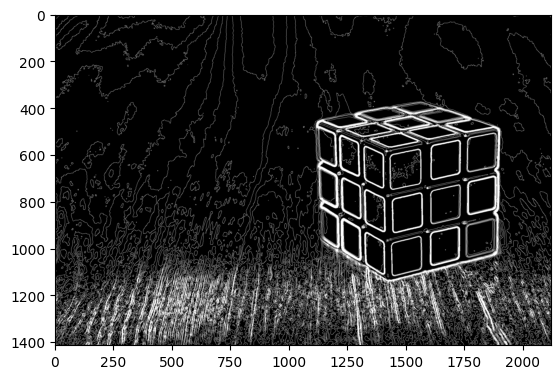

In [303]:
edged = cv2.GaussianBlur(edged,(3,3),0)
plt.imshow(edged, cmap="gray")

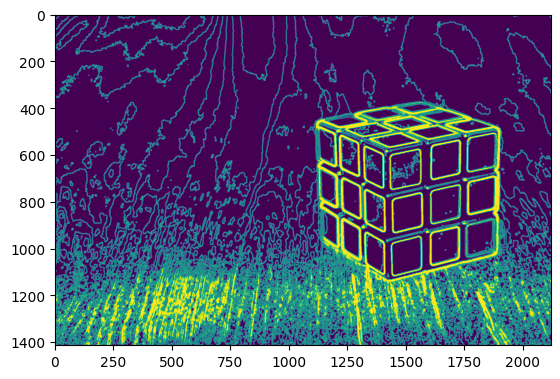

In [304]:
# chiusura dei buchi ed ingrossamento dei bordi
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, None)
plt.imshow(edged)

Number of Contours found = 1582


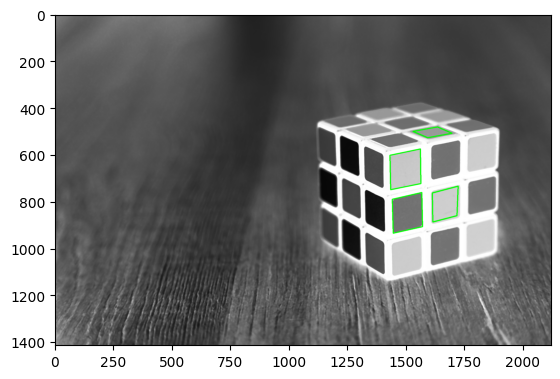

In [305]:
contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print("Number of Contours found = " + str(len(contours))) 

# filtra i contorni in al numero di angoli di un poligono + area
filtered_contours = []
for i, c in enumerate(contours):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))

    # approssimazione ad un poligono
    epsilon = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)
    
    # filtraggio
    if len(approx) == 4 and cv2.contourArea(approx) > 1000:
        filtered_contours.append(approx) 



# visualizza l'immagine risultante
tmp = cv2.cvtColor(HP_gray_image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(tmp, filtered_contours, -1, (0, 255, 0), thickness = 3)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

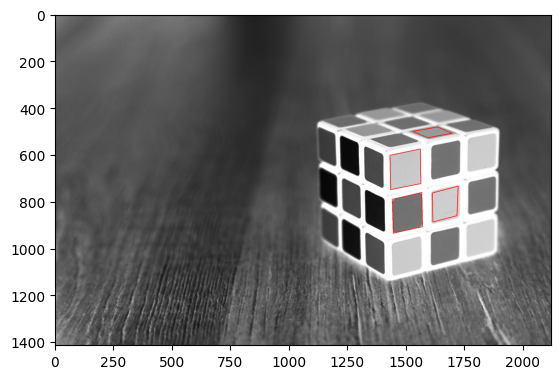

In [306]:
image_height, image_width, _ = image.shape
center_x = image_width // 2
center_y = image_height // 2

# duddivide i quadrati in base alla loro posizione rispetto al centro
top_quadrati = []
right_quadrati = []
left_quadrati = []
for contour in filtered_contours:

    # punto centrale di un quadratino
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # classificazione in base al centro del rubiks cube
    if cY < center_y - abs(center_x-cX)/2:
        top_quadrati.append(contour)
    elif cX > center_x:
        right_quadrati.append(contour)
    elif cX < center_x:
        left_quadrati.append(contour)

# output
tmp = cv2.cvtColor(HP_gray_image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(tmp, top_quadrati, -1, (0, 255, 0), 2)
cv2.drawContours(tmp, right_quadrati, -1, (0, 0, 255), 2)
cv2.drawContours(tmp, left_quadrati, -1, (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

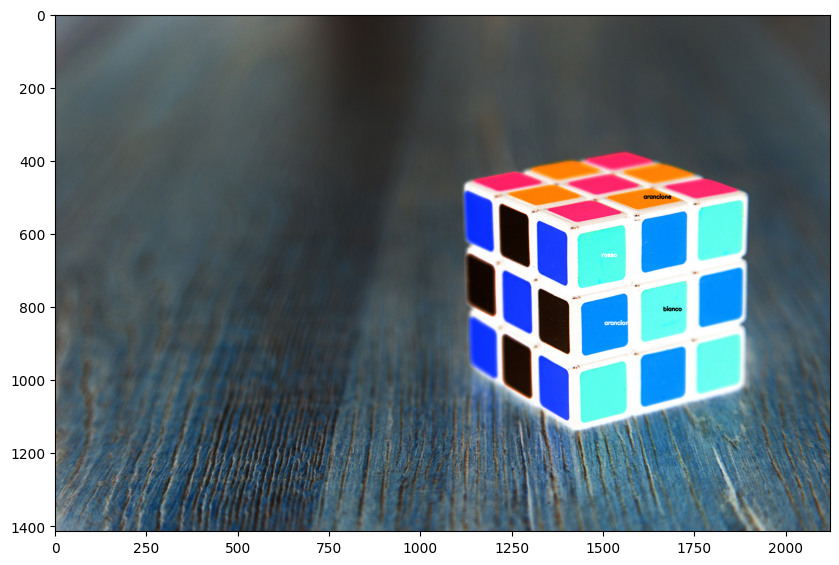

In [307]:
color_palette = {
    'rosso': (0, 0, 255),
    'verde': (0, 255, 0),
    'blu': (255, 0, 0),
    'bianco': (255, 255, 255),
    'giallo': (0, 255, 255),
    'arancione': (0, 165, 255)
}

for contour in filtered_contours:
    # trova il punto centrale del contour
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # lettura colore al punto centrale
    image = 255 - image
    color_at_center = image[cY, cX]

    # sampling del colore più vicino nella palette
    closest_color = min(color_palette.keys(), key=lambda x: np.linalg.norm(np.array(color_palette[x]) - color_at_center))

    # inserimento nome colore
    cv2.putText(image, closest_color, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

# output
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: False


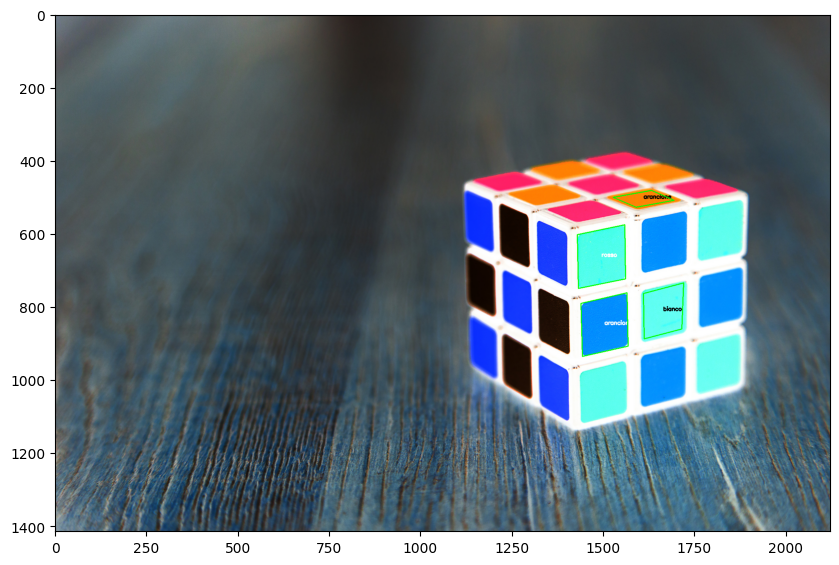

In [308]:
# completamento del cubo di rubik se non identificati tutti i quadrati

for contour in filtered_contours:
    vertices = contour.reshape(-1, 2)

    # vettore tra il primo e l'ultimo vertice
    vector1 = vertices[0] - vertices[1]
    vector2 = vertices[1] - vertices[2]
    vector3 = vertices[2] - vertices[3]
    vector4 = vertices[3] - vertices[0]

    # angolo tra il vettore e un vettore verticale (0, 1)
    angle1 = np.degrees(np.arctan2(vector1[1], vector1[0]))
    angle2 = np.degrees(np.arctan2(vector2[1], vector2[0]))
    angle3 = np.degrees(np.arctan2(vector3[1], vector3[0]))
    angle4 = np.degrees(np.arctan2(vector4[1], vector4[0]))

    # verifica se l'angolo è vicino a 90 gradi (verticale)
    is_vertical = np.isclose(angle1, 90.0, atol=10.0) or np.isclose(angle2, 90.0, atol=10.0) or np.isclose(angle3, 90.0, atol=10.0) or np.isclose(angle4, 90.0, atol=10.0)

    print(f"Uno dei lati è verticale: {is_vertical}")

    # disegna il quadrato sull'immagine originale
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

# visualizza l'immagine risultante
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))